In [268]:
import re
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set()
sns.set_style('darkgrid')
#sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})
sns.set_palette(sns.color_palette("Paired", 10))

country_tag = 'Country/Region'
state_tag = 'Province/State'

data_dir = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
filename_cases = data_dir + '/time_series_covid19_confirmed_global.csv'
filename_deaths = data_dir + '/time_series_covid19_deaths_global.csv'

cases_df = pd.read_csv(filename_cases)
deaths_df = pd.read_csv(filename_deaths)

#print('Countries:')
#print(deaths_df[country_tag].unique())
#deaths_df[deaths_df[country_tag] == 'Israel']
#deaths_df

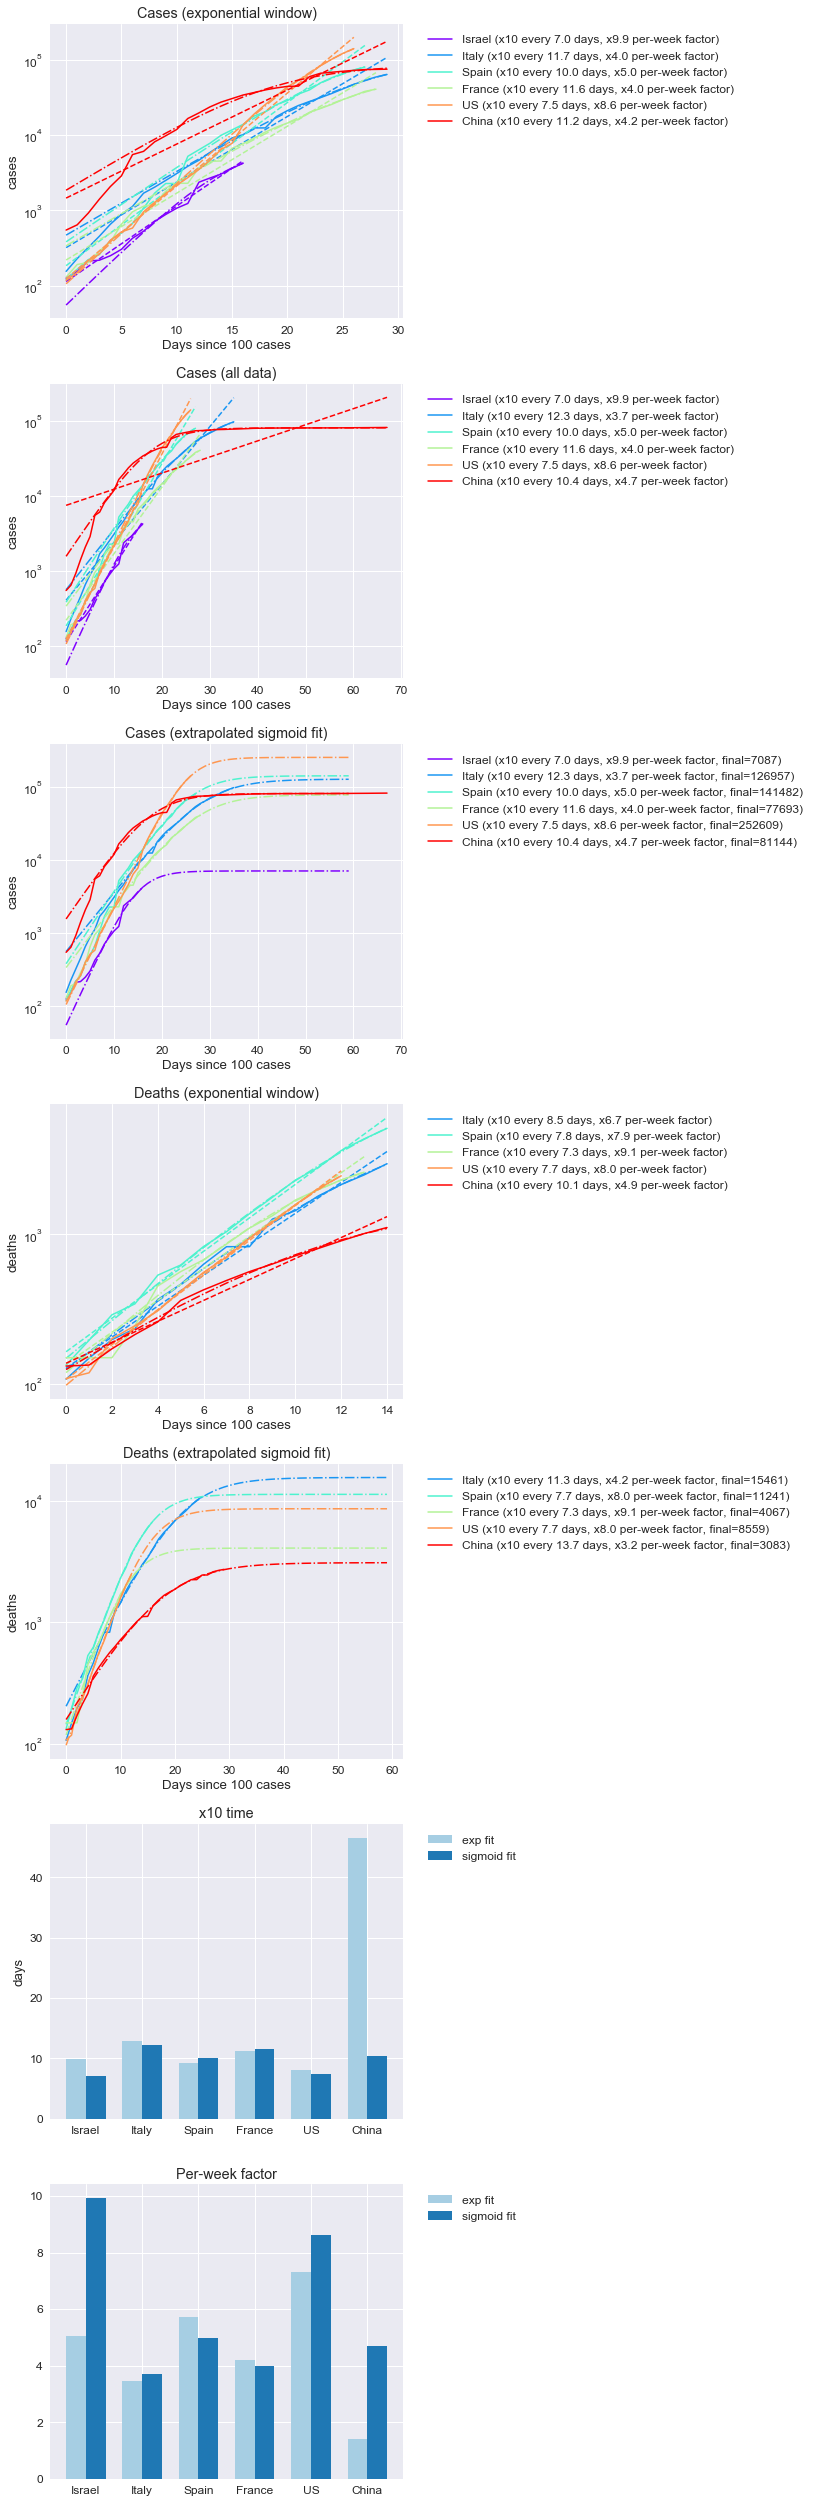

In [283]:

def get_dates(lst):
    return [d for d in lst if re.match(r'\d+/\d+/\d+', d)]
    
def find_exponential_fit(x, y):
    # y = c * exp(a * x)
    # log(y) = log(c) + a * x = intercept + slope * x
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, np.log(np.array(y, dtype=np.float32)))
    def model(x):
        return np.exp(intercept + slope * x)
    return model, slope

def sigmoid_fn(x, a, c1, c2):
    ret = c1 / (c2 + np.exp(-a*x))
    return np.array(ret, dtype=np.float64)

def find_sigmoid_fit(x, y):
    assert len(x) == len(y)
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    popt, pcov = scipy.optimize.curve_fit(sigmoid_fn, x, y, p0=(1., 1., 1.))
    def model_fn(x):
        return sigmoid_fn(*([x] + list(popt)))
    exponent = popt[0]
    return model_fn, exponent

def typical_time(exponent, factor=10):
    # y' / y = exp(slope * (x' - x)) = 2
    # x' - x = log(2) / slope
    return np.log(factor) / exponent

def per_week_factor(exponent):
    # y' / y = exp(slope * (x' - x)) = exp(7*slope)
    return np.exp(7. * np.array(exponent))

def compare_countries(ax, df, countries, y_label, legend=True, min_y=100, max_days=30, 
                      extrapolate_days=None, exp_fit=True, title=None):
    colors = {
        country: color for country, color in zip(countries, plt.cm.rainbow(np.linspace(0,1,len(countries))))
    }
    
    exponents = []
    sigmoid_exponents = []
    
    for c in countries:
        rows = df[df[country_tag] == c]
        if len(rows) == 0:
            raise ValueError('Query returned no results: ' + str(q))
        row = rows.sum(axis=0)
        days = get_dates(row.index)
        y = row[days]
        y = y[y > min_y]
        y = y[:max_days]
        
        if len(y) == 0:
            print("WARNING: Not enough {} data for {}".format(y_label, c))
            continue
        
        days_since = range(len(y))
        sigmoid_model, sigmoid_exponent = find_sigmoid_fit(days_since, y)
        sigmoid_exponents.append(sigmoid_exponent)

        if exp_fit:
            model, exponent = find_exponential_fit(days_since, y)
            exponents.append(exponent)
        
        ax.plot(days_since, y, '+-', color=colors[c], 
                label='{} (x10 every {:.1f} days, x{:.1f} per-week factor{})'.format(
                    c, typical_time(sigmoid_exponent), per_week_factor(sigmoid_exponent),
                    ', final={}'.format(int(sigmoid_model(extrapolate_days))) if extrapolate_days is not None else ''
                ))
        if exp_fit:
            ax.plot(days_since, model(days_since), '--', color=colors[c])#, label='{} model'.format(c))
        
        if extrapolate_days is None:
            extra_days = days_since
        else:
            extra_days = np.arange(extrapolate_days)
        ax.plot(extra_days, sigmoid_model(extra_days), '-.', color=colors[c])#, label='{} model'.format(c))
        ax.set_yscale('log')

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Days since {} cases'.format(min_y))
    ax.set_ylabel(y_label)
    if legend:
        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    return exponents, sigmoid_exponents
    
#countries = ['Israel', 'Italy', 'United Kingdom', 'Spain', 'Germany', 'France', 'China', 'US']
countries = ['Israel', 'Italy', 'Spain', 'France', 'US', 'China']

num_rows = 7
num_cols = 1
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows))
axi = iter(ax)

compare_countries(next(axi), cases_df, countries, y_label='cases', title='Cases (exponential window)')
exps, sig_exps = compare_countries(
    next(axi), cases_df, countries, y_label='cases', min_y=100, max_days=300, title='Cases (all data)')
compare_countries(
    next(axi), cases_df, countries, y_label='cases', min_y=100, max_days=300, extrapolate_days=60, exp_fit=False,
    title='Cases (extrapolated sigmoid fit)')
compare_countries(next(axi), deaths_df, countries, max_days=15, y_label='deaths', title='Deaths (exponential window)')
compare_countries(next(axi), deaths_df, countries, max_days=30, extrapolate_days=60, 
                  exp_fit=False, y_label='deaths', title='Deaths (extrapolated sigmoid fit)')

# Plot the exponents
ax = next(axi)
indices = np.arange(len(countries))
width = 0.35
ax.bar(indices, typical_time(exps), width, label='exp fit')
ax.bar(indices + width, typical_time(sig_exps), width, label='sigmoid fit')
ax.legend()
ax.set_title('x10 time')
ax.set_xticks(indices + width / 2.)
ax.set_xticklabels(countries)
ax.set_ylabel('days')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

ax = next(axi)
indices = np.arange(len(countries))
width = 0.35
ax.bar(indices, per_week_factor(exps), width, label='exp fit')
ax.bar(indices + width, per_week_factor(sig_exps), width, label='sigmoid fit')
ax.legend()
ax.set_title('Per-week factor')
ax.set_xticks(indices + width / 2.)
ax.set_xticklabels(countries)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

fig.tight_layout()
plt.show()


In [165]:
def compare_provinces(ax, df, country, legend, y_label, min_cases=200, max_days=30):
    queries = [{country: c} for c in countries]
    for q in queries:
        rows = df[df[country] == q[country]]
        if len(rows) == 0:
            raise ValueError('Query returned no results: ' + str(q))
        row = rows.sum(axis=0)
        days = get_dates(row.index)
        cases = row[days]
        cases = cases[cases > min_cases]
        cases = cases[:max_days]
        ax.plot(range(len(cases)), cases, '+-', label=q[country])
        ax.set_yscale('log')

    ax.set_xlabel('Days since {} cases'.format(min_cases))
    ax.set_ylabel(y_label)
    if legend:
        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

country = 'US'
df = cases_df

cases_df[cases_df[country_tag] == country]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,19100,25489,33276,43847,53740,65778,83836,101657,121478,140886
